# Analyze Portfolio for IRA - 3/23/2021

In [1]:
from platform import python_version
import time
from datetime import datetime
import os
import pandas as pd
import numpy as np
import math
import matplotlib as plt

%matplotlib inline

import importlib
import trading_functions as tf
importlib.reload(tf)

datafun = tf.Data()
portfun = tf.Portfolio()
retfun = tf.Returns()
selfun = tf.Selection()
factfun = tf.Factors()

import ameritrade_functions as amc
importlib.reload(amc)

plt.rcParams['figure.figsize'] = (20, 8)
print(f'Python version: {python_version()}')
print(f'Pandas version: {pd.__version__}')

Python version: 3.6.12
Pandas version: 0.22.0


## Configure Ameritrade Information

Ameritrade credentials are stored in environment variables to keep from having unencrypted passwords stored on disk.

The module automatically masks the account numbers to protect the actual accounts. An Ameritrade user can have many investment accounts. We will be working with only one for this demonstration.

In [2]:
username = os.getenv('maiotradeuser')
password = os.getenv('maiotradepw')
client_id = os.getenv('maiotradeclientid')

masked_account_number = '#---5311'
account_portfolios_file_name = 'data/portfolio_data.csv'
portfolio_file_name = 'data/portfolio_' + masked_account_number[-4:] + '.csv'
price_histories_file_name = 'data/price_histories_20210323.csv'

## Authentication Tokens

To get data from Ameritrade you will need to obtains a short time use token (there is a re-use token, but that has not been coded yet.)

To obtain a token, you will need to have a Chrome driver located somewhere on your system. This will allow the module to use your credentials to obtain an authentication token.

Some issues with the current system (I plan to fix these later) is that once the module opens the browser, you will need to open it on your screen. For some reason, if it's shrunk, it does not work properly. You will notice a flashing Chrome icon on your task bar. As soon as you start the authentication process, click on the icon to open the screen. At some time in the future I will move to another mechanism like flask to avoid needed the driver and to be able to run headless.

In [3]:
td_ameritrade = amc.AmeritradeRest(username, password, client_id)
td_ameritrade.authenticate()

if len(td_ameritrade.authorization) == 0:
    print('Error: No authorization data: {}'.format(td_ameritrade.authorization))
else:
    print('You have authorization')

You have authorization


## Get your account data

There are two different account functions, one that just provides high level account data, and one that also returns investment information for each account.

There is a lot of data that Ameritrade provides. I have only selected the fields that I thought were interesting. The raw data is stored in the amc class, so if you would like to get different or additional data, you can pull the raw json string and parse it.

- td_ameritrade.positions_data
- td_ameritrade.account_data

These functions will return Pandas data frames.

In [4]:
portfolios_list = td_ameritrade.parse_portfolios_list()
display(portfolios_list.sample(5))
account_data = td_ameritrade.parse_accounts()
display(account_data)
datafun.save_port_data(portfolios_list, portfolio_file_name)

,account,assetType,averagePrice,currentDayCost,currentDayProfitLoss,currentDayProfitLossPercentage,cusip,description,longQuantity,maintenanceRequirement,marketValue,previousSessionLongQuantity,settledLongQuantity,settledShortQuantity,shortQuantity,symbol,type
12,#---5311,EQUITY,0.14474,0.0,135.00,1.63,Q3860H107,0,45000.0,0.00,8410.50,45000.0,45000.0,0.0,0.0,FGPHF,0
2,#---5311,EQUITY,37.80134,0.0,-5.36,-0.15,316092501,0,67.0,3618.67,3618.67,67.0,67.0,0.0,0.0,FNCL,0
11,#---5311,EQUITY,127.46231,0.0,-3.77,-0.16,922908611,0,13.0,2285.79,2285.79,13.0,13.0,0.0,0.0,VBR,0
7,#---5311,EQUITY,232.60143,0.0,10.36,0.54,922908595,0,7.0,1945.86,1945.86,7.0,7.0,0.0,0.0,VBK,0
9,#---5311,EQUITY,142.56057,0.0,23.45,0.37,922908652,0,35.0,6417.95,6417.95,35.0,35.0,0.0,0.0,VXF,0


,initialBalances_cashBalance,initialBalances_totalCash,initialBalances_equity,initialBalances_moneyMarketFund,currentBalances_cashBalance,currentBalances_equity,currentBalances_moneyMarketFund,current_return
accountId,,,,,,,,
#---2021,0.0,0.0,10642.38,192.35,0.0,10715.72,192.35,0.006868
#---5311,0.0,0.0,114387.54,1768.09,0.0,115540.40,1768.09,0.010028
#---9216,0.0,0.0,5115.61,488.85,0.0,5133.66,488.85,0.003522


## Lets narrow it down to one account

Here you can get the data for a specific account. The functions will work with the full data set, but I imagine each account would be treated differently when it comes to managing the investments.

In [5]:
portfolios_list = datafun.read_port_data(portfolio_file_name)
account_portfolio_df = datafun.get_account_portfolio_data(portfolios_list, masked_account_number)
acct_port_market_df = portfun.get_market_values(account_portfolio_df)
display(acct_port_market_df)

,marketValue,longQuantity
symbol,,
DKNG,2567.50,50.00
EEENF,4.43,250.00
FGPHF,8410.50,45000.00
FNCL,3618.67,67.00
MMDA1,1768.08,1768.08
SCHA,2161.01,21.00
SCHF,9295.44,231.00
SCHM,6400.12,82.00
TLRY,14383.71,783.00


## Total Portfolio and Equity Values

In [6]:
total_portfolio_value = portfun.get_account_value(acct_port_market_df).round(2)
display(f'Account {masked_account_number} total value:  {total_portfolio_value}')

equity_investments_df = portfun.get_investments_by_type(account_portfolio_df, investment_type='EQUITY')
port_equi_values = portfun.get_market_values(equity_investments_df)
total_equity_value = portfun.get_account_value(port_equi_values).round(2)
display(f'Account {masked_account_number} equity value: {total_equity_value}')

symbols = portfun.get_investment_symbols(port_equi_values)
port_weights_equity = portfun.get_portfolio_weights(port_equi_values)
display(port_weights_equity*100)

'Account #---5311 total value:  123955.32'

'Account #---5311 equity value: 122187.24'

symbol
DKNG      2.101283
EEENF     0.003626
FGPHF     6.883288
FNCL      2.961578
SCHA      1.768605
SCHF      7.607537
SCHM      5.237961
TLRY     11.771859
VBK       1.592523
VBR       1.870727
VGK       7.913887
VTI      30.936536
VXF       5.252553
WKHS     14.098035
dtype: float64

## Add additional Symbols to investigate

In [7]:
symbols_of_interest = { symbol : [0, 0] for symbol in['AAPL', 'MSFT', 'GOOG', 'TSLA', 'MGM', 'PDYPF', 'COKE', 'IBM', 'NNXPF', 'BABA']}
interesting_port_equi_values = pd.DataFrame.from_dict(symbols_of_interest, orient='index')
interesting_port_equi_values.index.name='symbol'
interesting_port_equi_values.columns = ['marketValue', 'longQuantity']
new_port_equi_values = port_equi_values.append(interesting_port_equi_values)
display(new_port_equi_values)
display(portfun.get_portfolio_weights(new_port_equi_values))

,marketValue,longQuantity
symbol,,
DKNG,2567.50,50.0
EEENF,4.43,250.0
FGPHF,8410.50,45000.0
FNCL,3618.67,67.0
SCHA,2161.01,21.0
SCHF,9295.44,231.0
SCHM,6400.12,82.0
TLRY,14383.71,783.0
VBK,1945.86,7.0


symbol
AAPL     0.000000
BABA     0.000000
COKE     0.000000
DKNG     0.021013
EEENF    0.000036
FGPHF    0.068833
FNCL     0.029616
GOOG     0.000000
IBM      0.000000
MGM      0.000000
MSFT     0.000000
NNXPF    0.000000
PDYPF    0.000000
SCHA     0.017686
SCHF     0.076075
SCHM     0.052380
TLRY     0.117719
TSLA     0.000000
VBK      0.015925
VBR      0.018707
VGK      0.079139
VTI      0.309365
VXF      0.052526
WKHS     0.140980
dtype: float64

# Price History data

One you have a set of investments you want to work with, you will need to pull some historical data for them.

Eventually I plan to import the data into zipline, since they have an awesome set of analysis tools. But for now I'm using some functions I built to play with the data. 

### Skip if you alrady have histories

Unless you want to update them.

1 Year of daily fundamentatls data

In [8]:
number_of_years = 2
portfolio_price_histories = td_ameritrade.get_price_histories(new_port_equi_values.index, datetime.today().strftime('%Y-%m-%d'), num_periods=number_of_years)
datafun.save_price_histories(portfolio_price_histories, price_histories_file_name)

## Read saved data

In [9]:
portfolio_price_histories = datafun.read_price_histories(price_histories_file_name)
display(portfolio_price_histories.tail(5))

,close,high,low,open,volume,ticker,date
11142,143.8300,144.2700,143.4850,144.2100,412123,IBM,2021-05-28
11143,0.0177,0.0180,0.0175,0.0178,35055563,EEENF,2021-05-28
11144,2.8900,2.9254,2.8600,2.9048,3420,NNXPF,2021-05-28
11145,250.8765,252.0700,250.3400,250.9950,3410423,MSFT,2021-05-28
11146,213.6650,214.5300,212.0600,212.7600,2105997,BABA,2021-05-28


# Analysis tools

Once you have the historical data (currently pulling 1 year from today), you can start to evaluate the stocks using different functions.

In [10]:
current_weights = portfun.get_portfolio_weights(new_port_equi_values)
port_close = datafun.get_close_values(portfolio_price_histories)
display(port_close.tail(2))
port_returns = retfun.compute_returns(port_close)
display(port_returns.tail(2))

ticker,AAPL,BABA,COKE,DKNG,EEENF,FGPHF,FNCL,GOOG,IBM,MGM,...,SCHF,SCHM,TLRY,TSLA,VBK,VBR,VGK,VTI,VXF,WKHS
date,,,,,,,,,,,,,,,,,,,,,
2021-05-27,125.28,212.740,401.63,50.400,0.0178,0.1839,54.09,2402.51,143.82,43.79,...,40.04,77.9500,17.17,630.850,276.50,176.12,68.78,217.720,182.70,9.6200
2021-05-28,124.91,213.665,398.42,51.205,0.0177,0.1869,53.96,2416.29,143.83,43.02,...,40.23,77.9736,18.10,624.674,277.76,175.76,69.03,218.355,183.26,9.5089


ticker,AAPL,BABA,COKE,DKNG,EEENF,FGPHF,FNCL,GOOG,IBM,MGM,...,SCHF,SCHM,TLRY,TSLA,VBK,VBR,VGK,VTI,VXF,WKHS
date,,,,,,,,,,,,,,,,,,,,,
2021-05-27,-0.012377,0.004533,0.024723,0.019005,-0.027322,-0.065549,0.011595,-0.012747,0.003069,0.021699,...,0.002253,0.006586,0.029994,0.01893,0.005308,0.010674,0.003063,0.001841,0.007166,0.053669
2021-05-28,-0.002953,0.004348,-0.007992,0.015972,-0.005618,0.016313,-0.002403,0.005736,0.000070,-0.017584,...,0.004745,0.000303,0.054164,-0.00979,0.004557,-0.002044,0.003635,0.002917,0.003065,-0.011549


## Alpha Factors

In [11]:
import trading_factors as factors

all_factors = pd.concat(
    [
        factors.momentum(portfolio_price_histories, 120),
        factors.mean_revision_factor_returns(portfolio_price_histories, 5),
        factors.mean_revision_factor_returns_smoothed(portfolio_price_histories, 5),
        factors.overnight_sentiment(portfolio_price_histories, 5),
        factors.overnight_sentiment_smoothed(portfolio_price_histories, 5)
    ], axis=1)
all_factors.sort_index(inplace=True)

assets = all_factors.index.levels[1].values.tolist()
pricing = datafun.get_close_values(portfolio_price_histories)
clean_factor_data, unixt_factor_data = factors.prepare_alpha_lense_factor_data(all_factors, pricing)

Dropped 23.9% entries from factor data: 23.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 1.2% entries from factor data: 1.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 1.0% entries from factor data: 1.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


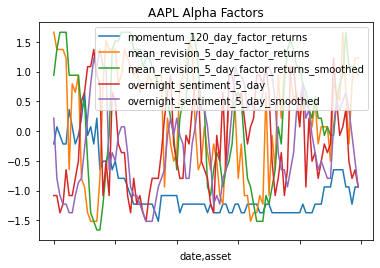

In [12]:
all_factors[all_factors.index.isin(['AAPL'], level=1)].tail(100).plot(title='AAPL Alpha Factors')

## PCA to compute portfolio variance

In [13]:
num_factor_exposures = 20

C:\Users\nmaiorana\anaconda3\envs\ai-for-trading\lib\site-packages\pandas\plotting\_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)


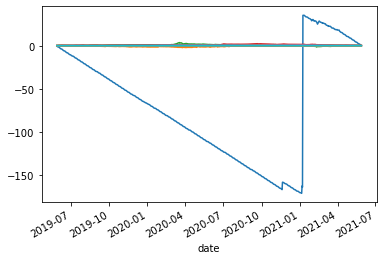

In [14]:
risk_model = factors.RiskModelPCA(port_returns, 1, num_factor_exposures)
risk_model.factor_returns_.cumsum().plot(legend=None)

In [15]:
var_portfolio = risk_model.compute_portfolio_variance(current_weights)
print(f'portfolio variance is:  {var_portfolio:.8f}')

portfolio variance is:  0.02450728


## Quantile Analysis
### Factor Returns
Let's view the factor returns over time. We should be seeing it generally move up and to the right.

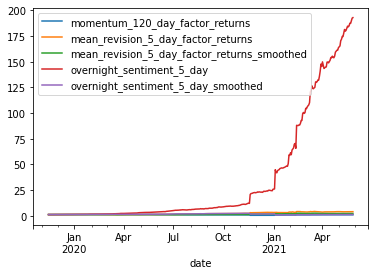

In [16]:
import alphalens as al
ls_factor_returns = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:, 0]

(1+ls_factor_returns).cumprod().plot()

### Basis Points Per Day per Quantile
It is not enough to look just at the factor weighted return. A good alpha is also monotonic in quantiles. Let's looks the basis points for the factor returns.

C:\Users\nmaiorana\anaconda3\envs\ai-for-trading\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\nmaiorana\anaconda3\envs\ai-for-trading\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\nmaiorana\anaconda3\envs\ai-for-trading\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\nmaiorana\anacond

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F7CCA697B8>,
      dtype=object)

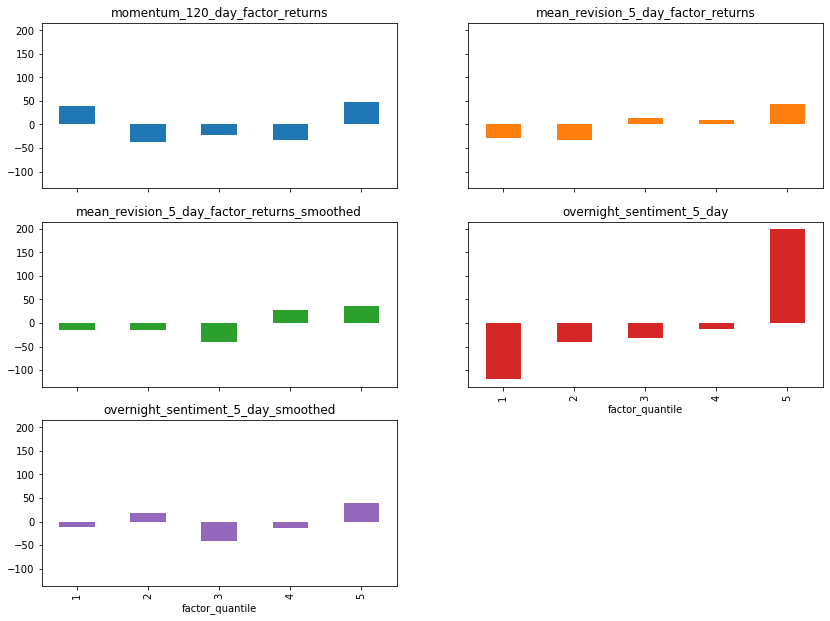

In [17]:
qr_factor_returns = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    qr_factor_returns[factor] = al.performance.mean_return_by_quantile(factor_data)[0].iloc[:, 0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(4,2),
    figsize=(14, 14),
    legend=False)

What do you observe?

- None of these alphas are **strictly monotonic**; this should lead you to question why this is? Further research and refinement of the alphas needs to be done. What is it about these alphas that leads to the highest ranking stocks in all alphas except MR 5D smoothed to *not* perform the best.
- The majority of the return is coming from the **short side** in all these alphas. The negative return in quintile 1 is very large in all alphas. This could also a cause for concern becuase when you short stocks, you need to locate the short; shorts can be expensive or not available at all.
- If you look at the magnitude of the return spread (i.e., Q1 minus Q5), we are working with daily returns in the 0.03%, i.e., **3 basis points**, neighborhood *before all transaction costs, shorting costs, etc.*. Assuming 252 days in a year, that's 7.56% return annualized. Transaction costs may cut this in half. As such, it should be clear that these alphas can only survive in an institutional setting and that leverage will likely need to be applied in order to achieve an attractive return.

## Turnover Analysis

Without doing a full and formal backtest, we can analyze how stable the alphas are over time. Stability in this sense means that from period to period, the alpha ranks do not change much. Since trading is costly, we always prefer, all other things being equal, that the ranks do not change significantly per period. We can measure this with the **factor rank autocorrelation (FRA)**.

[alphalens.performance.factor_rank_autocorrelation](https://quantopian.github.io/alphalens/alphalens.html?highlight=factor_rank_autocorrelation#alphalens.performance.factor_rank_autocorrelation)

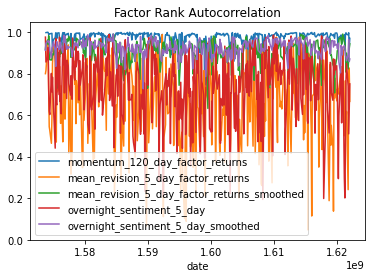

In [18]:
ls_FRA = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(factor_data)

ls_FRA.plot(title="Factor Rank Autocorrelation")

In [19]:
factfun.sharpe_ratio(ls_factor_returns, 'daily').round(2)

,Sharpe Ratio
momentum_120_day_factor_returns,0.27
mean_revision_5_day_factor_returns,1.96
mean_revision_5_day_factor_returns_smoothed,1.09
overnight_sentiment_5_day,4.11
overnight_sentiment_5_day_smoothed,0.53


## The Combined Alpha Vector

To use these alphas in a portfolio, we need to combine them somehow so we get a single score per stock. This is a area where machine learning can be very helpful. In this module, however, we will take the simplest approach of combination: simply averaging the scores from each alpha.

In [20]:
selected_factors = all_factors.columns[[1, 2, 3]]
print('Selected Factors: {}'.format(', '.join(selected_factors)))

all_factors['alpha_vector'] = all_factors[selected_factors].mean(axis=1)
alphas = all_factors[['alpha_vector']]
alpha_vector = alphas.loc[all_factors.index.get_level_values(0)[-1]]
alpha_vector
#alpha_vector.sort_values(by=['alpha_vector'], ascending=False)

Selected Factors: mean_revision_5_day_factor_returns, mean_revision_5_day_factor_returns_smoothed, overnight_sentiment_5_day


,alpha_vector
asset,
AAPL,0.409312
BABA,1.179781
COKE,-0.698238
DKNG,-0.601929
EEENF,1.035318
FGPHF,-0.072232
FNCL,0.698238
GOOG,-0.457466
IBM,0.553775


# Optimal Portfolio Constrained by Risk Model
You have an alpha model and a risk model. Let's find a portfolio that trades as close as possible to the alpha model but limiting risk as measured by the risk model. You'll be building thie optimizer for this portfolio. To help you out. we have provided you with an abstract class called `AbstractOptimalHoldings`.

In [21]:
from abc import ABC, abstractmethod
import cvxpy as cvx

class AbstractOptimalHoldings(ABC):    
    @abstractmethod
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        
        raise NotImplementedError()
    
    @abstractmethod
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        
        raise NotImplementedError()
        
    def _get_risk(self, weights, factor_betas, alpha_vector_index, factor_cov_matrix, idiosyncratic_var_vector):
        f = factor_betas.loc[alpha_vector_index].values.T @ weights
        X = factor_cov_matrix
        S = np.diag(idiosyncratic_var_vector.loc[alpha_vector_index].values.flatten())

        return cvx.quad_form(f, X) + cvx.quad_form(weights, S)
    
    def find(self, alpha_vector, factor_betas, factor_cov_matrix, idiosyncratic_var_vector):
        weights = cvx.Variable(len(alpha_vector))
        risk = self._get_risk(weights, factor_betas, alpha_vector.index, factor_cov_matrix, idiosyncratic_var_vector)
        
        obj = self._get_obj(weights, alpha_vector)
        constraints = self._get_constraints(weights, factor_betas.loc[alpha_vector.index].values, risk)
        
        prob = cvx.Problem(obj, constraints)
        prob.solve(max_iters=500)

        optimal_weights = np.asarray(weights.value).flatten()
        
        return pd.DataFrame(data=optimal_weights, index=alpha_vector.index, columns=['optimalWeights'])

## Objective and Constraints
Using this class as a base class, you'll implement the `OptimalHoldings` class. There's two functions that need to be implemented in this class, the `_get_obj` and `_get_constraints` functions.

The `_get_obj` function should return an CVXPY objective function that maximizes $ \alpha^T * x \\ $, where $ x $ is the portfolio weights and $ \alpha $ is the alpha vector.

The `_get_constraints` function should return a list of the following constraints:
- $ r \leq risk_{\text{cap}}^2 \\ $
- $ B^T * x \preceq factor_{\text{max}} \\ $
- $ B^T * x \succeq factor_{\text{min}} \\ $
- $ x^T\mathbb{1} = 0 \\ $
- $ \|x\|_1 \leq 1 \\ $
- $ x \succeq weights_{\text{min}} \\ $
- $ x \preceq weights_{\text{max}} $

Where $ x $ is the portfolio weights, $ B $ is the factor betas, and $ r $ is the portfolio risk

The first constraint is that the predicted risk be less than some maximum limit. The second and third constraints are on the maximum and minimum portfolio factor exposures. The fourth constraint is the "market neutral constraint: the sum of the weights must be zero. The fifth constraint is the leverage constraint: the sum of the absolute value of the weights must be less than or equal to 1.0. The last are some minimum and maximum limits on individual holdings.

In [22]:
class OptimalHoldings(AbstractOptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)

        #TODO: Implement function
        
        return cvx.Maximize(alpha_vector.values.T @ weights)
    
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        assert(len(factor_betas.shape) == 2)
        
        #TODO: Implement function
        B = factor_betas
        constraints = [
            risk <= self.risk_cap ** 2,
            B.T @ weights <= self.factor_max,
            B.T @ weights >= self.factor_min,
            sum(weights) == 1.0,
            sum(cvx.abs(weights)) <= 1.0,
            weights <= self.weights_max,
            weights >= self.weights_min
        ]
        return constraints

    def __init__(self, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min


### View Data
With the `OptimalHoldings` class implemented, let's see the weights it generates.

,optimalWeights
asset,
AAPL,0.00
BABA,20.00
COKE,0.00
DKNG,0.00
EEENF,0.52
FGPHF,0.00
FNCL,20.00
GOOG,0.00
IBM,20.00


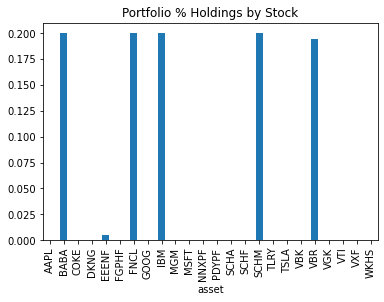

In [23]:
optimal_weights = OptimalHoldings(risk_cap=0.05,weights_max=0.20, weights_min=-0.05).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)
display((optimal_weights*100).round(2))
optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
#x_axis = plt.axes().get_xaxis()
#x_axis.set_visible(False)

In [24]:
print(f'Current investment amount: {total_equity_value}')
optimal_weights['amount'] = (optimal_weights['optimalWeights'] * total_equity_value).round(0)
optimal_weights['marketValue'] = new_port_equi_values['marketValue']
optimal_weights['buy/sell'] = (optimal_weights['marketValue'] - optimal_weights['amount']) * -1
optimal_weights['close'] = port_close.iloc[-1]
optimal_weights['existingShares'] = new_port_equi_values['longQuantity']
optimal_weights['deltaShares'] = (optimal_weights['buy/sell'] / optimal_weights['close']).round(0)
optimal_weights['deltaMarketValue'] = (optimal_weights['deltaShares'] * optimal_weights['close'])
optimal_weights['totalShares'] = (optimal_weights['existingShares'] + optimal_weights['deltaShares'])
optimal_weights['totalMarketValue'] = (optimal_weights['totalShares'] * optimal_weights['close'])
optimal_weights

Current investment amount: 122187.24


,optimalWeights,amount,marketValue,buy/sell,close,existingShares,deltaShares,deltaMarketValue,totalShares,totalMarketValue
asset,,,,,,,,,,
AAPL,2.824847e-10,0.0,0.00,-0.00,124.9100,0.0,-0.0,-0.0000,0.0,0.0000
BABA,2.000000e-01,24437.0,0.00,24437.00,213.6650,0.0,114.0,24357.8100,114.0,24357.8100
COKE,2.352988e-11,0.0,0.00,-0.00,398.4200,0.0,-0.0,-0.0000,0.0,0.0000
DKNG,2.509946e-11,0.0,2567.50,-2567.50,51.2050,50.0,-50.0,-2560.2500,0.0,0.0000
EEENF,5.246936e-03,641.0,4.43,636.57,0.0177,250.0,35964.0,636.5628,36214.0,640.9878
FGPHF,4.565948e-11,0.0,8410.50,-8410.50,0.1869,45000.0,-45000.0,-8410.5000,0.0,0.0000
FNCL,2.000000e-01,24437.0,3618.67,20818.33,53.9600,67.0,386.0,20828.5600,453.0,24443.8800
GOOG,2.819487e-11,0.0,0.00,-0.00,2416.2900,0.0,-0.0,-0.0000,0.0,0.0000
IBM,2.000000e-01,24437.0,0.00,24437.00,143.8300,0.0,170.0,24451.1000,170.0,24451.1000


## Think or Swim Simulator

In [25]:
optimal_weights[optimal_weights['totalShares'] > 0]

,optimalWeights,amount,marketValue,buy/sell,close,existingShares,deltaShares,deltaMarketValue,totalShares,totalMarketValue
asset,,,,,,,,,,
BABA,0.200000,24437.0,0.00,24437.00,213.6650,0.0,114.0,24357.8100,114.0,24357.8100
EEENF,0.005247,641.0,4.43,636.57,0.0177,250.0,35964.0,636.5628,36214.0,640.9878
FNCL,0.200000,24437.0,3618.67,20818.33,53.9600,67.0,386.0,20828.5600,453.0,24443.8800
IBM,0.200000,24437.0,0.00,24437.00,143.8300,0.0,170.0,24451.1000,170.0,24451.1000
SCHM,0.200000,24437.0,6400.12,18036.88,77.9736,82.0,231.0,18011.9016,313.0,24405.7368
VBR,0.194753,23796.0,2285.79,21510.21,175.7600,13.0,122.0,21442.7200,135.0,23727.6000


In [26]:
optimal_weights[optimal_weights['totalShares'] <= 0]

,optimalWeights,amount,marketValue,buy/sell,close,existingShares,deltaShares,deltaMarketValue,totalShares,totalMarketValue
asset,,,,,,,,,,
AAPL,2.824847e-10,0.0,0.00,-0.00,124.9100,0.0,-0.0,-0.0000,0.0,0.0000
COKE,2.352988e-11,0.0,0.00,-0.00,398.4200,0.0,-0.0,-0.0000,0.0,0.0000
DKNG,2.509946e-11,0.0,2567.50,-2567.50,51.2050,50.0,-50.0,-2560.2500,0.0,0.0000
FGPHF,4.565948e-11,0.0,8410.50,-8410.50,0.1869,45000.0,-45000.0,-8410.5000,0.0,0.0000
GOOG,2.819487e-11,0.0,0.00,-0.00,2416.2900,0.0,-0.0,-0.0000,0.0,0.0000
MGM,1.999441e-11,0.0,0.00,-0.00,43.0200,0.0,-0.0,-0.0000,0.0,0.0000
MSFT,3.261299e-11,0.0,0.00,-0.00,250.8765,0.0,-0.0,-0.0000,0.0,0.0000
NNXPF,1.936829e-11,0.0,0.00,-0.00,2.8900,0.0,-0.0,-0.0000,0.0,0.0000
PDYPF,1.111937e-10,0.0,0.00,-0.00,187.1900,0.0,-0.0,-0.0000,0.0,0.0000


In [27]:
optimal_weights[optimal_weights['totalShares'] > 0][['deltaMarketValue', 'totalMarketValue']].sum()

deltaMarketValue    109728.6544
totalMarketValue    122027.1146
dtype: float64